# Get Started

Last update: September 9th (2023) Hajime Kawahara for v1.5

First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (`*db`), 
(2) calculating opacity (`opa`),
(3) running atmospheric radiative transfer (`art`),
(4) applying operations on the spectrum (`sop`)

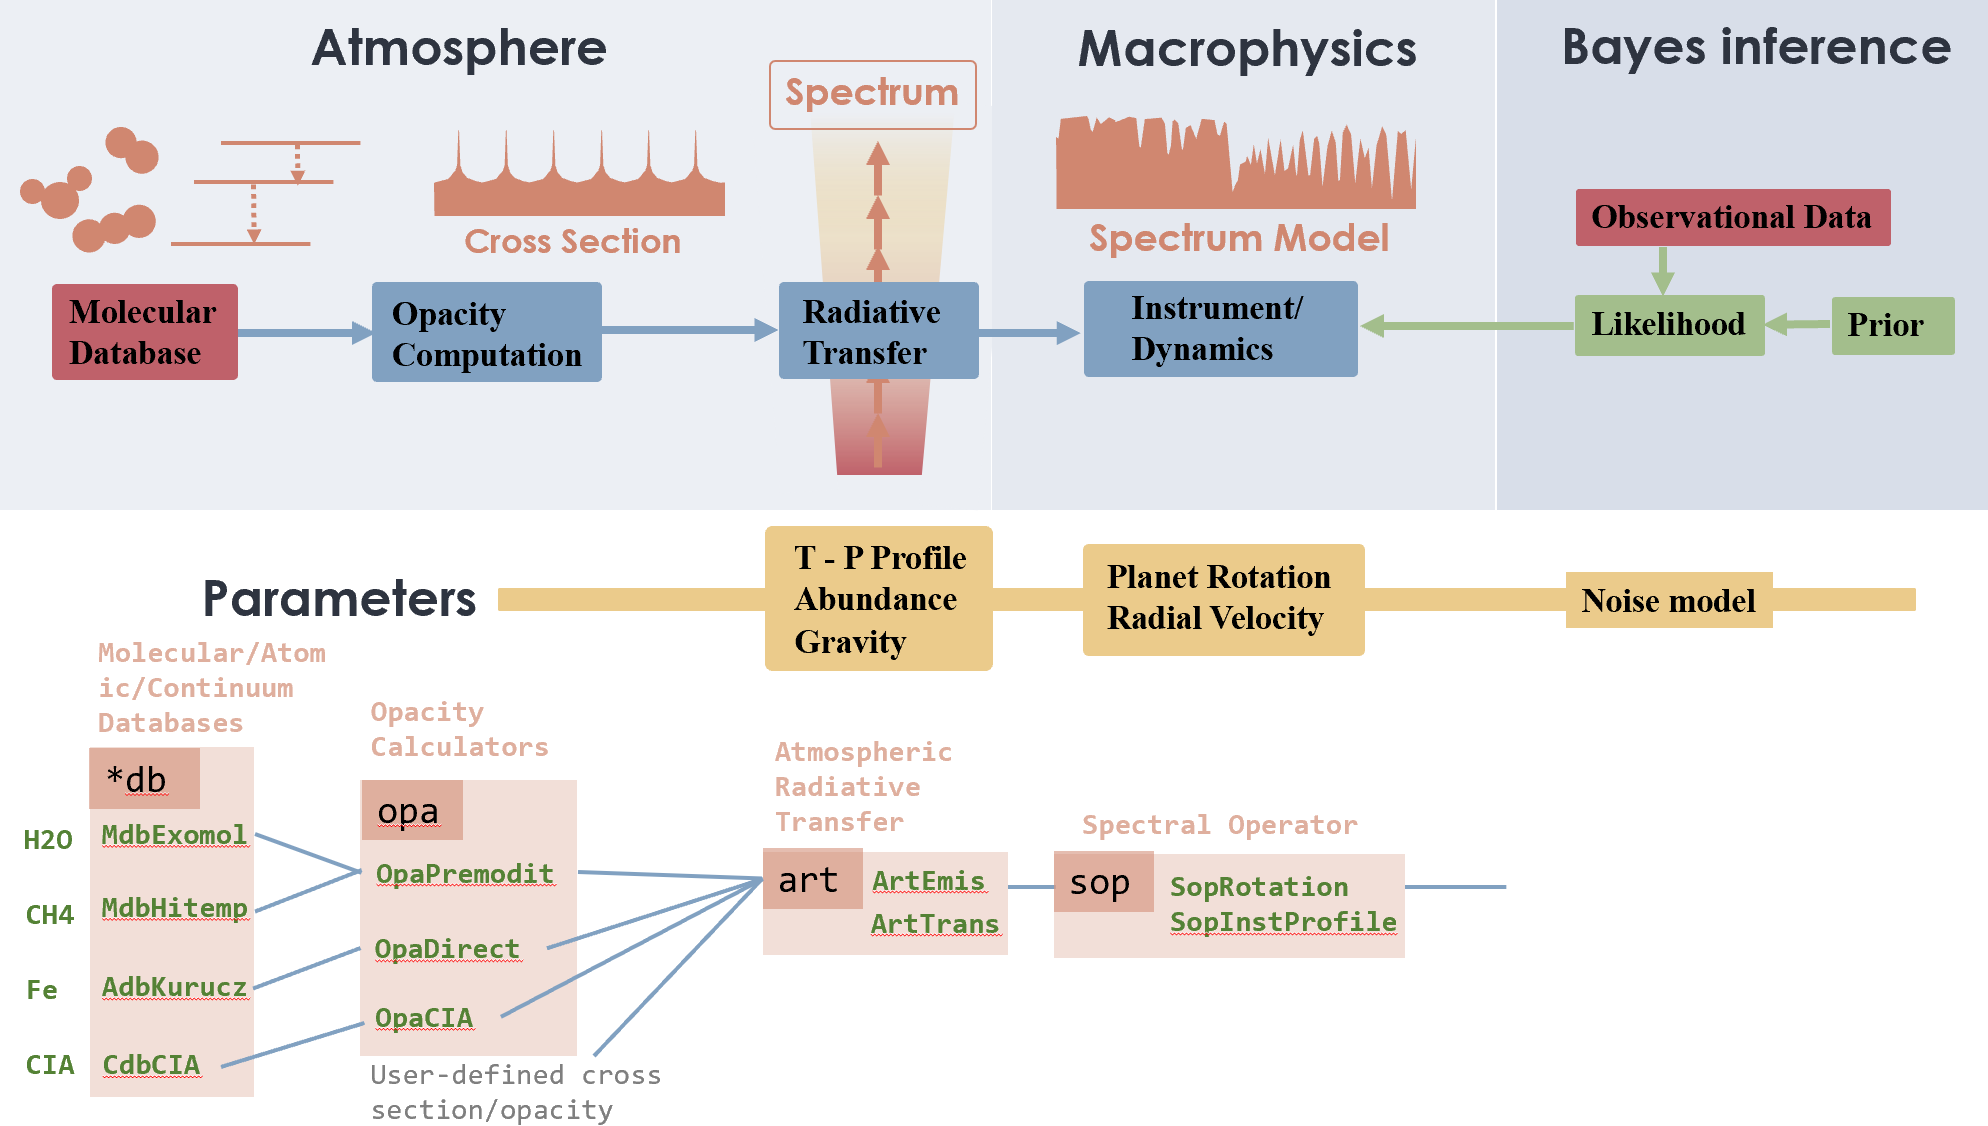

In [2]:
from IPython.display import Image
Image("../exojax.png")

## 1. Loading a molecular database using mdb.

ExoJAX has an API for molecular databases, called `mdb` (or `adb` for atomic datbases). Prior to loading the database, define the wavenumber range first.

In [3]:
from exojax.utils.grids import wavenumber_grid

nu_grid, wav, resolution = wavenumber_grid(1900.,
                                           2300.,
                                           100000,
                                           unit="cm-1",
                                           xsmode="premodit")


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
We changed the policy of the order of wavenumber/wavelength grids
wavenumber grid should be in ascending order and now 
users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
This might causes the bug if you update ExoJAX. 
Note that the older ExoJAX assumes ascending order as wavelength grid.


/home/kawahara/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=523403.606697253
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Then, let's load the molecular database. We here use Carbon monoxide in Exomol. `CO/12C-16O/Li2015` means `Carbon monoxide/ isotopes = 12C + 16O / database name`. You can check the database name in the ExoMol website (https://www.exomol.com/).  

In [4]:
from exojax.spec.api import MdbExomol

mdb = MdbExomol(".database/CO/12C-16O/Li2015", nurange=nu_grid)


/home/kawahara/exojax/src/exojax/utils/molname.py:178: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.def
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.pf
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.states.bz2
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__H2.broad
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__He.broad
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/12C-16O__air.broad
Error: Couldn't download .broad file at http://www.exomol.com/db/CO/12C-16O/12C-16O__air.broad and save.
Note: Caching states data to the vaex format. After the second time, it will become much faster.
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
		 => Downloading from http://www.exomol.com/db/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2

/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:606: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


## 2. Computation of the Cross Section using opa

ExoJAX has various opacity calculator classes, so-called `opa`. Here, we use a memory-saved opa, `OpaPremodit`. We assume the robust tempreature range we will use is 500-1500K.

In [5]:
from exojax.spec.opacalc import OpaPremodit

opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0])

OpaPremodit: params automatically set.
Robust range: 484.50562701065246 - 1531.072955816165 K
Tref changed: 296.0K->553.9182980610753K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
# of reference width grid :  4
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 5656.51it/s]


Premodit: Twt= 1153.8856089961712 K Tref= 553.9182980610753 K
Making LSD:|####################| 100%


Then let's compute cross section for two different temperature 500 and 1500 K for P=1.0 bar. opa.xsvector can do that!

In [6]:
P = 1.0 #bar
T_1 = 500.0 #K
xsv_1 = opa.xsvector(T_1, P) #cm2

T_2 = 1500.0 #K
xsv_2 = opa.xsvector(T_2, P) #cm2

Plot them. It can be seen that different lines are stronger at different temperatures.

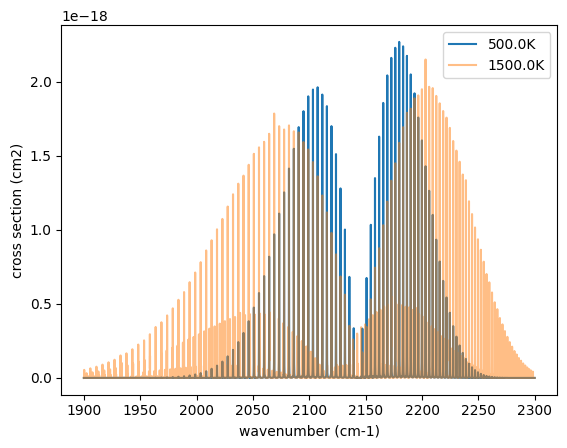

In [7]:
import matplotlib.pyplot as plt
plt.plot(nu_grid,xsv_1,label=str(T_1)+"K") #cm2
plt.plot(nu_grid,xsv_2,alpha=0.5,label=str(T_2)+"K") #cm2
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

You can also plot the line strengths at T=1500K. We can first change the `mdb` reference temperature and then plot the line intensity.

Tref changed: 553.9182980610753K->1500.0K


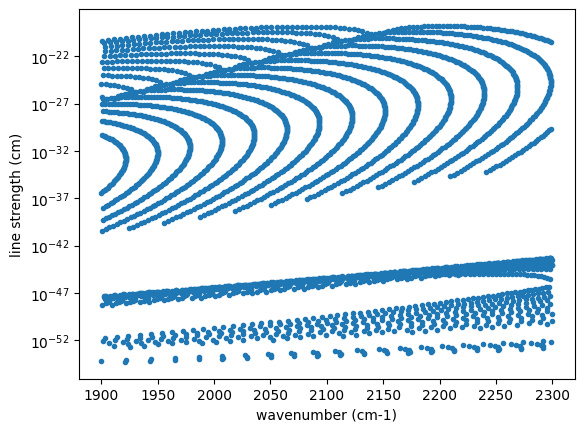

In [8]:
mdb.change_reference_temperature(T_2)
plt.plot(mdb.nu_lines,mdb.line_strength_ref,".")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("line strength (cm)")
plt.yscale("log")
plt.show()

## 3. Atmospheric Radiative Transfer

ExoJAX can solve the radiative transfer and derive the emission spectrum. To do so, ExoJAX has `art` class. `ArtEmisPure` means Atomospheric Radiative Transfer for Emission with Pure absorption. So, `ArtEmisPure` does not include scattering.
We set the number of the atmospheric layer to 200 (nlayer) and the pressure at bottom and top atmosphere to 100 and 1.e-5 bar.

Since v1.5, one can choose the rtsolver (radiative transfer solver) from the flux-based 2 stream solver (`fbase2st`) and the intensity-based n-stream sovler (`ibased`). Use `rtsolver` option. In the latter case, the number of the stream (`nstream`) can be specified.

In [9]:
from exojax.spec.atmrt import ArtEmisPure
art = ArtEmisPure(nu_grid=nu_grid, pressure_btm=1.e1, pressure_top=1.e-8, nlayer=75, rtsolver="ibased", nstream=8)


rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Let's assume the power law temperature model, within 500 - 1500 K.

$T = T_0 P^\alpha$

where $T_0=1200$ K and $\alpha=0.1$.

In [10]:
art.change_temperature_range(500.0, 1500.0)
Tarr = art.powerlaw_temperature(1200.0,0.1)

Also, the mass mixing ratio of CO (MMR) should be defined.

In [11]:
mmr_profile = art.constant_mmr_profile(0.01)

Surface gravity is also important quantity of the atmospheric model, which is a function of planetary radius and mass. Here we assume 1 RJ and 10 MJ.

In [12]:
from exojax.utils.astrofunc import gravity_jupiter
gravity = gravity_jupiter(1.0,10.0)

In addition to the CO cross section, we would consider [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity. `cdb` class can be used.

In [13]:
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA

cdb = CdbCIA(".database/H2-H2_2011.cia",nurange=nu_grid)
opacia = OpaCIA(cdb, nu_grid=nu_grid)

H2-H2


Before running the radiative transfer, we need cross sections for layers, called `xsmatrix` for CO and `logacia_matrix` for CIA (strictly speaking, the latter is not cross section but coefficient because CIA intensity is proportional density square). 

In [14]:
xsmatrix = opa.xsmatrix(Tarr, art.pressure)
logacia_matrix = opacia.logacia_matrix(Tarr)

Convert them to opacity

In [16]:
dtau_CO = art.opacity_profile_xs(xsmatrix, mmr_profile, mdb.molmass, gravity)
vmrH2 = 0.855 #VMR of H2
mmw = 2.33 # mean molecular weight of the atmosphere
dtaucia = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2, mmw, gravity)

Add two opacities.

In [17]:
dtau = dtau_CO + dtaucia

Then, run the radiative transfer

Gaussian Quadrature Parameters: 
mu =  [0.06943184 0.33000948 0.66999052 0.93056816]
weight = [0.17392742 0.32607258 0.32607258 0.17392742]


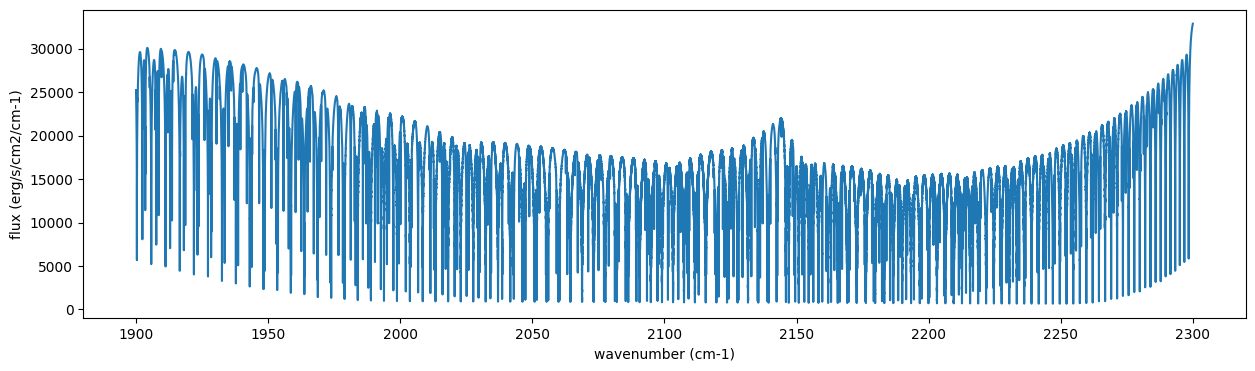

In [18]:
F = art.run(dtau, Tarr)

fig=plt.figure(figsize=(15,4))
plt.plot(nu_grid,F)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

You can check the contribution function too! 
You should check if the dominant contribution is within the layer. 
If not, you need to change `pressure_top` and `pressure_btm` in `ArtEmisPure`    

In [19]:
from exojax.plot.atmplot import plotcf

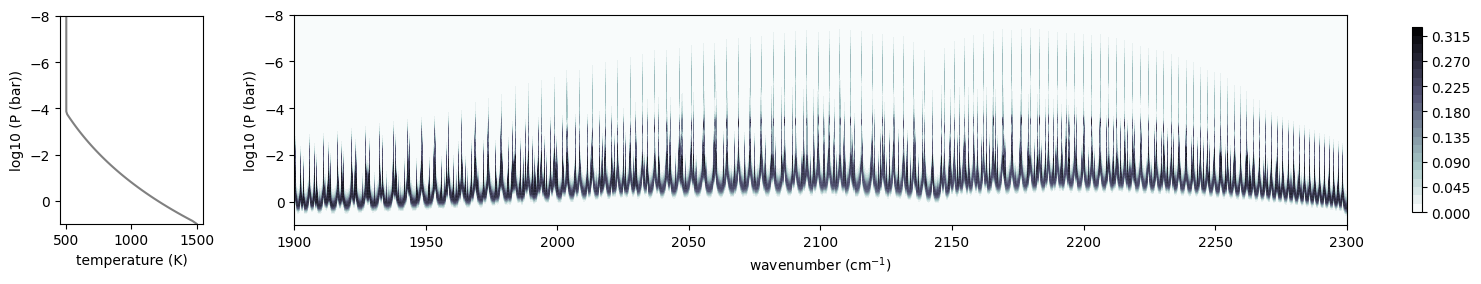

In [20]:
cf=plotcf(nu_grid, dtau, Tarr,art.pressure, art.dParr)

## Spectral Operators: rotational broadening, instrumental profile, Doppler velocity shift and so on, any operation on spectra.

The above spectrum is called "raw spectrum" in ExoJAX. The effects applied to the raw spectrum is handled in ExoJAX by the spectral operator (`sop`).
First, we apply the spin rotational broadening of a planet.

In [21]:
from exojax.spec.specop import SopRotation
sop_rot = SopRotation(nu_grid, resolution, vsini_max=100.0)

vsini = 50.0
u1=0.0
u2=0.0 
Frot = sop_rot.rigid_rotation(F, vsini, u1, u2) 

/home/kawahara/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=523403.606697253
  warnings.warn('Resolution may be too small. R=' + str(resolution),


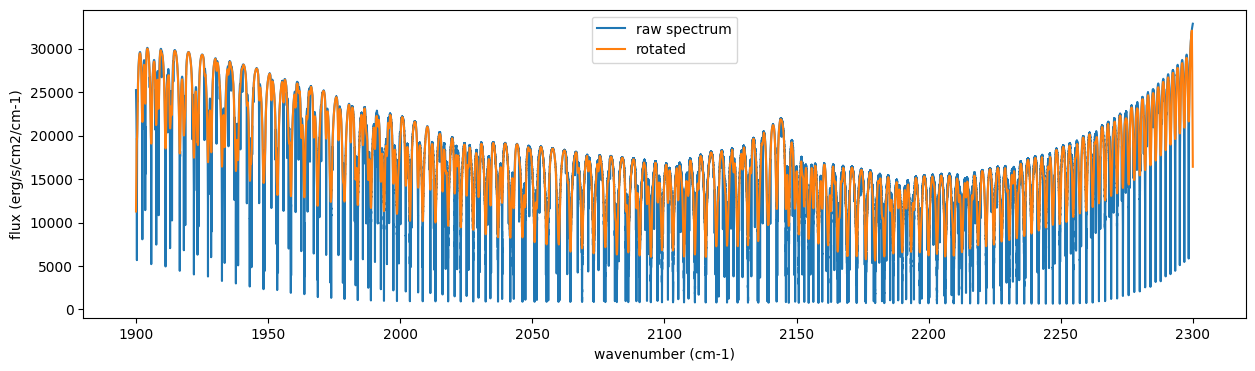

In [22]:
fig=plt.figure(figsize=(15,4))
plt.plot(nu_grid,F, label="raw spectrum")
plt.plot(nu_grid,Frot, label="rotated")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
plt.show()

Then, the instrumental profile with relative radial velocity shift is applied. Also, we need to match the computed spectrum to the data grid. This process is called `sampling` (but just interpolation though).

In [23]:
from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std
sop_inst = SopInstProfile(nu_grid, resolution, vrmax=1000.0)

RV=40.0 #km/s
resolution_inst = 3000.0
beta_inst = resolution_to_gaussian_std(resolution_inst)
Finst = sop_inst.ipgauss(Frot, beta_inst)
nu_obs = nu_grid[::50]
Fobs = sop_inst.sampling(Finst, RV, nu_obs)

/home/kawahara/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=523403.606697253
  warnings.warn('Resolution may be too small. R=' + str(resolution),


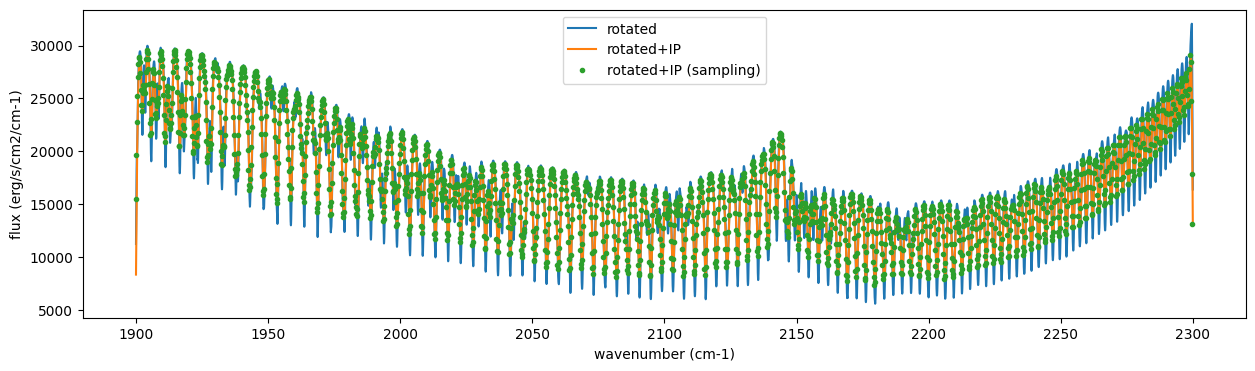

In [24]:
fig=plt.figure(figsize=(15,4))
plt.plot(nu_grid,Frot, label="rotated")
plt.plot(nu_grid,Finst, label="rotated+IP")
plt.plot(nu_obs,Fobs, ".", label="rotated+IP (sampling)")


plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
plt.show()

That's it. 